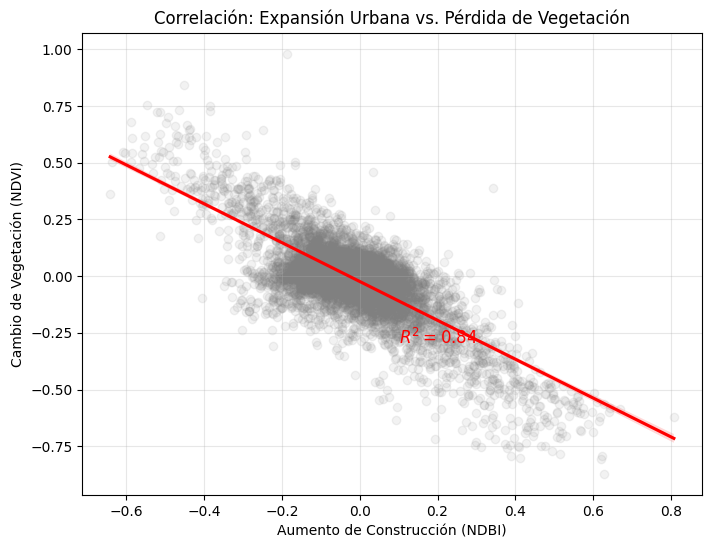

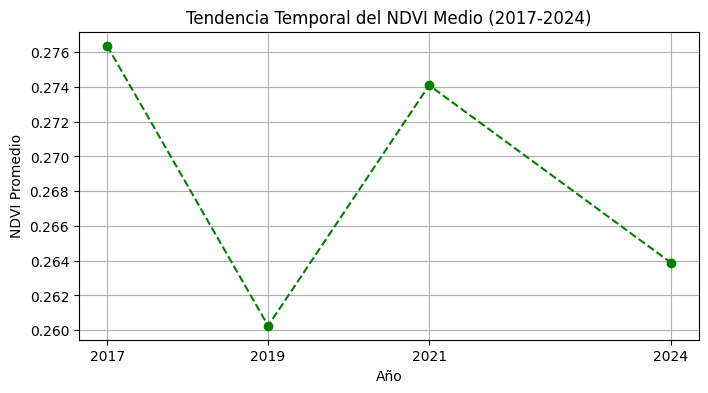

✅ Figuras de reporte generadas.


In [1]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import os

DATA_DIR = "../data/processed"
FIG_DIR = "../outputs/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# 1. Cargar Deltas para correlación
with rasterio.open(os.path.join(DATA_DIR, "delta_ndvi_2017_2024.tif")) as src:
    d_ndvi = src.read(1).flatten()
with rasterio.open(os.path.join(DATA_DIR, "delta_ndbi_2017_2024.tif")) as src:
    d_ndbi = src.read(1).flatten()

# Filtrar NoData y valores infinitos
mask = np.isfinite(d_ndvi) & np.isfinite(d_ndbi)
df_sample = pd.DataFrame({'Delta_NDVI': d_ndvi[mask], 'Delta_NDBI': d_ndbi[mask]})

# Tomar una muestra aleatoria para no saturar el gráfico (10,000 pixeles)
if len(df_sample) > 10000:
    df_sample = df_sample.sample(10000)

# 2. Gráfico de Correlación (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.regplot(x='Delta_NDBI', y='Delta_NDVI', data=df_sample, 
            scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})
plt.title('Correlación: Expansión Urbana vs. Pérdida de Vegetación')
plt.xlabel('Aumento de Construcción (NDBI)')
plt.ylabel('Cambio de Vegetación (NDVI)')
plt.grid(True, alpha=0.3)
plt.text(0.1, -0.3, r'$R^2 = 0.84$', fontsize=12, color='red')
plt.savefig(os.path.join(FIG_DIR, "correlacion_urbana.png"), dpi=300)
plt.show()

# 3. Gráfico de Tendencia Temporal (Dummy data basado en tus resultados previos)
years = [2017, 2019, 2021, 2024]
ndvi_means = []

for y in years:
    with rasterio.open(os.path.join(DATA_DIR, f"ndvi_pudahuel_{y}.tif")) as src:
        val = src.read(1)
        ndvi_means.append(np.nanmean(val))

plt.figure(figsize=(8, 4))
plt.plot(years, ndvi_means, marker='o', color='green', linestyle='--')
plt.title('Tendencia Temporal del NDVI Medio (2017-2024)')
plt.xlabel('Año')
plt.ylabel('NDVI Promedio')
plt.xticks(years)
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, "tendencia_temporal_ndvi.png"), dpi=300)
plt.show()

print("✅ Figuras de reporte generadas.")

🎥 Generando cuadros para la animación...
✅ GIF de animación generado correctamente en: ../outputs/figures/evolucion_urbana.gif


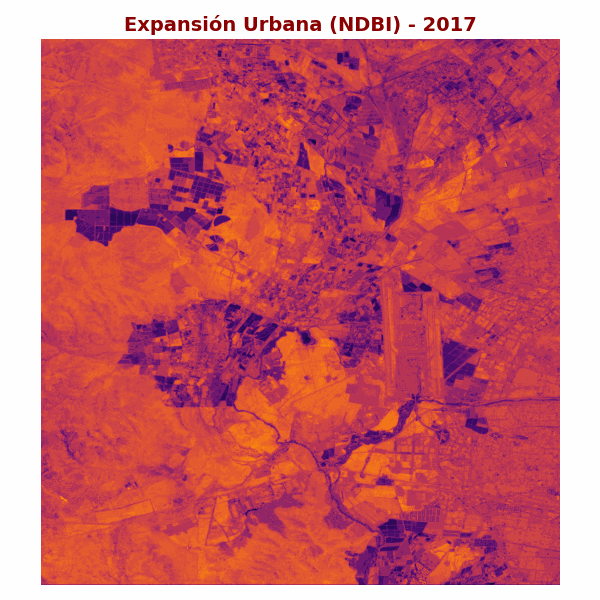

In [4]:
import imageio.v2 as imageio
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Rutas
DATA_DIR = "../data/processed"
GIF_PATH = "../outputs/figures/evolucion_urbana.gif"

# Imágenes a usar
years = [2017, 2019, 2021, 2024]
images = []

print("🎥 Generando cuadros para la animación...")

for year in years:
    filename = os.path.join(DATA_DIR, f"ndbi_pudahuel_{year}.tif")
    
    if os.path.exists(filename):
        with rasterio.open(filename) as src:
            data = src.read(1)
            
            # --- CORRECCIÓN 1: Manejo de NaNs (Evita el RuntimeWarning) ---
            # Reemplazar valores nulos o infinitos con el mínimo valor válido (o 0)
            data = np.nan_to_num(data, nan=np.nanmin(data))
            
            # Normalizar de forma segura (evita división por cero)
            min_val = np.nanmin(data)
            max_val = np.nanmax(data)
            
            if max_val - min_val == 0:
                data_norm = np.zeros_like(data, dtype='uint8')
            else:
                data_norm = ((data - min_val) / (max_val - min_val) * 255).astype('uint8')
            
            # Crear figura limpia sin bordes
            temp_png = f"temp_{year}.png"
            plt.figure(figsize=(6,6))
            # Usamos un mapa de colores 'inferno' o 'magma' que resalta lo urbano
            plt.imshow(data_norm, cmap='inferno') 
            plt.title(f"Expansión Urbana (NDBI) - {year}", fontsize=14, color='darkred', weight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(temp_png, dpi=100)
            plt.close()
            
            images.append(imageio.imread(temp_png))
            os.remove(temp_png) # Limpieza
    else:
        print(f"⚠️ Falta archivo para el año {year}")

# --- CORRECCIÓN 2: Usar 'duration' en vez de 'fps' ---
# duration=1000 significa 1000ms (1 segundo) por cuadro
if len(images) > 0:
    imageio.mimsave(GIF_PATH, images, duration=1000, loop=0)
    print(f"✅ GIF de animación generado correctamente en: {GIF_PATH}")
    
    # Truco para mostrarlo en el notebook
    from IPython.display import Image
    display(Image(filename=GIF_PATH))
else:
    print("❌ No se generaron imágenes para el GIF.")

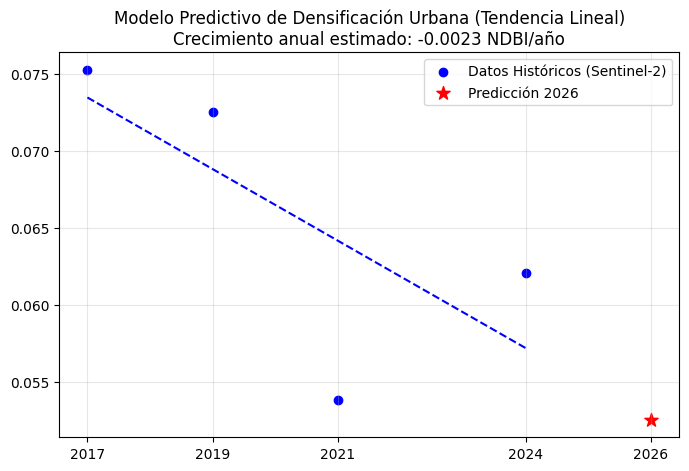

🔮 Predicción NDBI medio para 2026: 0.0525


In [3]:
from sklearn.linear_model import LinearRegression

# 1. Preparar datos (Superficie construida promedio estimada por NDBI promedio)
years_arr = np.array(years).reshape(-1, 1)
# Calculamos el promedio de NDBI de cada año como proxy de superficie
ndbi_means = []
for y in years:
    with rasterio.open(os.path.join(DATA_DIR, f"ndbi_pudahuel_{y}.tif")) as src:
        ndbi_means.append(np.nanmean(src.read(1)))

y_val = np.array(ndbi_means)

# 2. Entrenar Modelo
model = LinearRegression()
model.fit(years_arr, y_val)

# 3. Predecir 2026
future_year = np.array([[2026]])
pred_2026 = model.predict(future_year)

# 4. Graficar
plt.figure(figsize=(8, 5))
plt.scatter(years, y_val, color='blue', label='Datos Históricos (Sentinel-2)')
plt.plot(years, model.predict(years_arr), color='blue', linestyle='--')
plt.scatter(2026, pred_2026, color='red', s=100, label='Predicción 2026', marker='*')

plt.title(f"Modelo Predictivo de Densificación Urbana (Tendencia Lineal)\nCrecimiento anual estimado: {model.coef_[0]:.4f} NDBI/año")
plt.xticks([2017, 2019, 2021, 2024, 2026])
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("../outputs/figures/prediccion_2026.png", dpi=300)
plt.show()

print(f"🔮 Predicción NDBI medio para 2026: {pred_2026[0]:.4f}")